**In this notebook, I extracted the keywords, they were generated in 02**

Experimenting  
Some of the keywords were not generated (lenght limit), considering them missing.

In [1]:
import re
import ast
from collections import Counter
from typing import List, Tuple, Dict, Any
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")
pd.options.display.max_colwidth = 200

# Paths - change if needed
META_CSV = "main_df_1.csv"                 # metadata file (contains TRACK_ID etc)
CAPTIONS_CSV = "optpim_captions_checkpoint.csv"   # your captions CSV (TRACK_ID, caption)
OUT_CSV = "captions_with_keywords.csv"     # save results

In [18]:
import re
from typing import List, Tuple

# ---- helper cleaning ----
BAD_PREFIXES = re.compile(r'^(a |an |the |it |its |like |such |this |that )', flags=re.IGNORECASE)
BAD_PHRASES = [
    "the song", "it sounds", "suggested tags", "keywords", "suggested", "recommended", "example",
    "the answer", "the total", "software", "programming", "coding"
]

def normalize_token(tok: str) -> str:
    tok = str(tok).strip()
    # remove leading/trailing punctuation and quotes
    tok = re.sub(r'^[\s\W_]+|[\s\W_]+$', '', tok)
    tok = re.sub(r'\s+', ' ', tok)
    return tok

def is_high_confidence_token(tok: str) -> bool:
    """
    Conservative checks to avoid sentence fragments and junk.
    Conditions to accept:
      - length <= 4 words
      - does not start with bad prefixes (a/the/it/like)
      - does not contain certain bad phrases
      - contains at least one alpha character
    """
    if not tok:
        return False
    if len(re.findall(r'\w+', tok)) == 0:
        return False
    # word count
    wc = len(tok.split())
    if wc > 4:
        return False
    # drop if starts with filler
    if BAD_PREFIXES.match(tok.lower()):
        return False
    tl = tok.lower()
    for bp in BAD_PHRASES:
        if bp in tl:
            return False
    # drop tokens that look like sentence fragments with periods mid token
    if '.' in tok and not tok.strip().endswith('.'):
        return False
    return True

# ---- splitting with conservative rules ----
def split_candidates(text: str) -> List[str]:
    """
    Conservative splitting into candidate tags.
    Steps:
      - remove label markers at start
      - split on pipes/semicolons/slashes, then on commas
      - normalize each candidate and filter by is_high_confidence_token
    """
    if text is None:
        return []
    t = str(text).strip()
    # remove obvious markers/prefixes
    t = re.sub(r'^(keywords?|keyword|suggested tags?|suggested|tags?)\s*[:\-]?\s*', '', t, flags=re.IGNORECASE)
    # split heavy separators first
    parts = re.split(r'[\/;\|]+', t)
    tokens = []
    for p in parts:
        if not p or len(p.strip()) == 0:
            continue
        # if comma present -> split on commas (most common)
        if ',' in p:
            for sub in p.split(','):
                tok = normalize_token(sub)
                if tok:
                    tokens.append(tok)
        else:
            tok = normalize_token(p)
            if tok:
                tokens.append(tok)
    # final cleaning and filter
    out = []
    seen = set()
    for tok in tokens:
        # remove trailing dots and stray punctuation
        tok = re.sub(r'[\.]+$', '', tok).strip()
        if tok == "":
            continue
        if not is_high_confidence_token(tok):
            continue
        low = tok.lower()
        if low not in seen:
            seen.add(low)
            out.append(low)
    return out

# ---- quick list-likelihood test ----
def looks_like_tag_list(text: str) -> bool:
    if not text or len(text.strip()) == 0:
        return False
    # strong signals: commas, pipes, semicolons, or short comma-separated tokens
    if ',' in text or '|' in text or ';' in text or '/' in text:
        return True
    # if short (<=6 words) and mostly lower-case words/phrases maybe a list (but be conservative)
    words = text.split()
    if len(words) <= 6 and all(re.match(r'^[A-Za-z\-]+$', w) for w in words[:6]):
        return True
    return False

# ---- main extraction function (conservative, prefer marker-first) ----
def extract_keywords_from_caption(caption: str) -> Tuple[List[str], str]:
    """
    Returns (keywords, method). Methods: keywords_field, keywords_field_nextline,
    trailing_double_pipe, trailing_pipe, trailing_paren, last_line_list, trailing_after_dot, none
    """
    if caption is None:
        return [], "none"
    s = str(caption).strip()
    if s == "":
        return [], "none"

    # split consistent lines
    lines = [ln.strip() for ln in s.splitlines() if ln.strip() != ""]
    joined = " ".join(lines)

    # 1) Strict marker capture on same line "Keywords: a, b, c"
    m_marker = re.search(r'\b(keywords?|suggested tags?|suggested|tags?)\s*[:\-]?\s*(.+)$', s, flags=re.IGNORECASE)
    if m_marker:
        tail = m_marker.group(2).strip()
        # if tail contains list markers, parse it
        if looks_like_tag_list(tail):
            tokens = split_candidates(tail)
            if tokens:
                return tokens, "keywords_field"
        # else try next line(s) but only if they look like a list
        # find which line contained the marker
        for i, ln in enumerate(lines):
            if re.search(r'\b(keywords?|suggested tags?|suggested|tags?)\b', ln, flags=re.IGNORECASE):
                if i + 1 < len(lines) and looks_like_tag_list(lines[i+1]):
                    tokens = split_candidates(lines[i+1])
                    if tokens:
                        return tokens, "keywords_field_nextline"
                break

    # 2) trailing '||' or single '|'
    if '||' in s:
        right = s.rsplit('||', 1)[1].strip()
        if looks_like_tag_list(right):
            tokens = split_candidates(right)
            if tokens:
                return tokens, "trailing_double_pipe"
    if '|' in s:
        right = s.rsplit('|', 1)[1].strip()
        if looks_like_tag_list(right):
            tokens = split_candidates(right)
            if tokens:
                return tokens, "trailing_pipe"

    # 3) trailing parenthetical list (...)
    m_paren = re.search(r'\(([^)]+)\)\s*$', s)
    if m_paren:
        cand = m_paren.group(1)
        if looks_like_tag_list(cand):
            tokens = split_candidates(cand)
            if tokens:
                return tokens, "trailing_paren"

    # 4) trailing fragment after last period but only if it looks like tag list
    if '.' in s:
        last_sent = s.rsplit('.', 1)[1].strip()
        if looks_like_tag_list(last_sent):
            tokens = split_candidates(last_sent)
            if tokens:
                return tokens, "trailing_after_dot"

    # 5) last-line fallback: only if last line looks list-like
    if lines:
        last_line = lines[-1]
        if looks_like_tag_list(last_line):
            tokens = split_candidates(last_line)
            if tokens:
                return tokens, "last_line_list"
        # last-2-lines combined if combined looks like list
        if len(lines) >= 2:
            combo = lines[-2] + " " + lines[-1]
            if looks_like_tag_list(combo):
                tokens = split_candidates(combo)
                if tokens:
                    return tokens, "last_lines_combined"

    # 6) regex fallback: capture sequence of comma-separated words near end (conservative)
    m_tail = re.search(r'([A-Za-z0-9\-\s]{3,120}\s*,\s*[A-Za-z0-9\-\s]{1,120}\s*(?:,\s*[A-Za-z0-9\-\s]{1,120}){1,6})\s*\.?\s*$', s)
    if m_tail:
        cand = m_tail.group(1)
        if looks_like_tag_list(cand):
            tokens = split_candidates(cand)
            if tokens:
                return tokens, "regex_tail_list"

    return [], "none"

In [ ]:
ccaptions_df = pd.read_csv(CAPTIONS_CSV, dtype=str).fillna("")

# make sure columns exist
if "TRACK_ID" not in captions_df.columns or "caption" not in captions_df.columns:
    raise RuntimeError("captions CSV must contain TRACK_ID and caption columns.")

# run extraction
from tqdm.notebook import tqdm
tqdm.pandas(desc="extracting (improved)")
captions_df["extracted_keywords"], captions_df["kw_method"] = zip(
    *captions_df["caption"].progress_map(extract_keywords_from_caption)
)

captions_df["n_keywords"] = captions_df["extracted_keywords"].apply(len)

# QUICK SANITY TEST 
sample_idxs = [5458, 2112, 2256, 4422, 9911, 13257]
print("Sanity check for specific samples:")
for idx in sample_idxs:
    if idx < len(captions_df):
        print(f"\nINDEX {idx} | METHOD: {captions_df.loc[idx,'kw_method']} | n_keywords: {captions_df.loc[idx,'n_keywords']}")
        print("Caption:", captions_df.loc[idx, "caption"])
        print("Extracted:", captions_df.loc[idx, "extracted_keywords"][:10])
    else:
        print("Index out of range:", idx)

# head + basic stats (will show coverage)
print("\nSummary statistics:")
print("Fraction of captions with extracted keywords: %.3f%%" % (100.0 * (captions_df["n_keywords"] > 0).mean()))
print("Method counts:\n", captions_df["kw_method"].value_counts())

captions_df.head()

In [21]:
captions_df.to_csv(OUT_CSV, index=False)

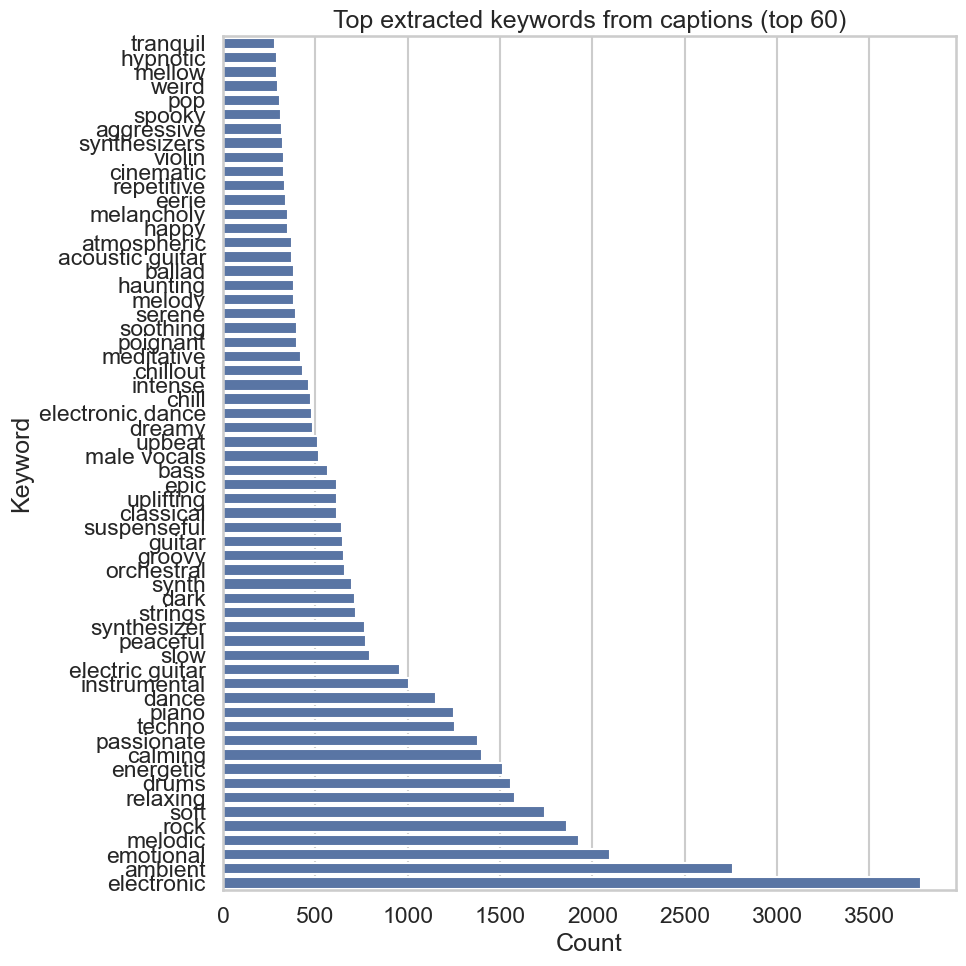

In [22]:
exploded = captions_df.explode("extracted_keywords")
exploded["extracted_keywords"] = exploded["extracted_keywords"].fillna("").astype(str)
top = exploded[exploded["extracted_keywords"] != "" ]["extracted_keywords"].value_counts().head(60)

plt.figure(figsize=(10, 10))
sns.barplot(y=top.index[::-1], x=top.values[::-1])
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.title("Top extracted keywords from captions (top 60)")
plt.tight_layout()

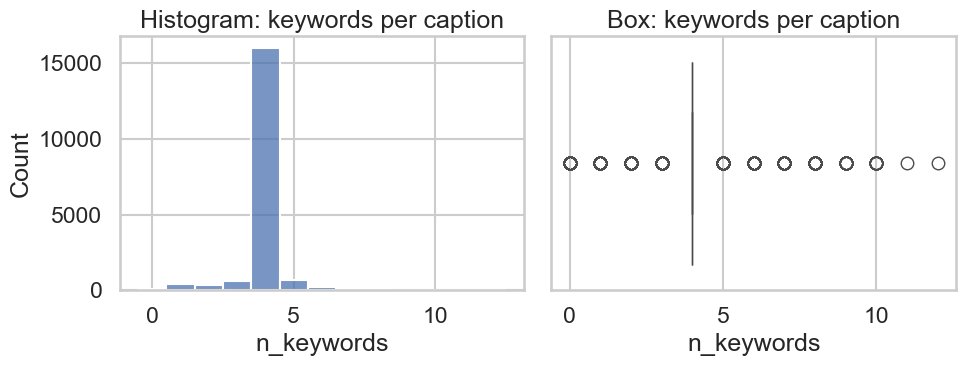

In [23]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1)
sns.histplot(captions_df["n_keywords"], bins=range(0,8), discrete=True)
plt.title("Histogram: keywords per caption")
plt.xlabel("n_keywords")

ax = plt.subplot(1,2,2)
sns.boxplot(x=captions_df["n_keywords"])
plt.title("Box: keywords per caption")
plt.tight_layout()

Fraction of captions with extracted keywords: 99.481%
Extraction method counts:
 kw_method
keywords_field          13838
trailing_double_pipe     2057
trailing_pipe            1754
last_line_list            523
trailing_after_dot        218
none                       96
Name: count, dtype: int64


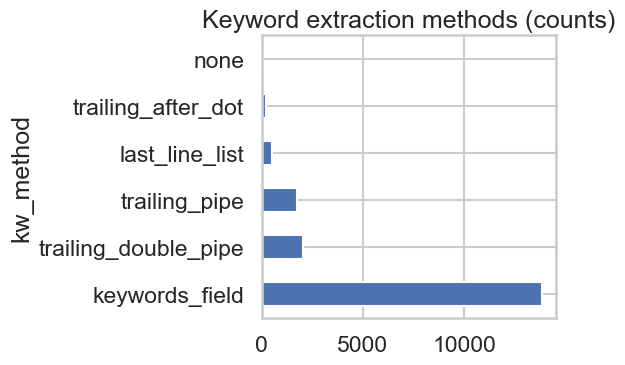

In [24]:
coverage = (captions_df["n_keywords"] > 0).mean()
print(f"Fraction of captions with extracted keywords: {coverage:.3%}")

method_counts = captions_df["kw_method"].value_counts()
print("Extraction method counts:\n", method_counts)

plt.figure(figsize=(6,4))
method_counts.plot(kind="barh")
plt.title("Keyword extraction methods (counts)")
plt.tight_layout()


In [25]:
print("== Samples with keywords ==")
display(captions_df[captions_df["n_keywords"]>0].sample(6)[["TRACK_ID","caption","extracted_keywords","kw_method"]])

print("\n== Samples WITHOUT keywords ==")
display(captions_df[captions_df["n_keywords"]==0].sample(6)[["TRACK_ID","caption"]])

== Samples with keywords ==


,TRACK_ID,caption,extracted_keywords,kw_method
17470,track_1397348,"Melancholic piano piece with a sense of resolution. || resolution, emotional depth, contemplative, serene","[resolution, emotional depth, contemplative, serene]",trailing_double_pipe
12909,track_1263270,"Melancholic piano piece with emotional depth, played beautifully, possibly for a sad movie scene. Keywords: piano, melancholy, emotional, beauty.","[piano, melancholy, emotional, beauty]",keywords_field
14946,track_1330444,"A slow pop ballad featuring a piano and guitar with soft drums and bassline. Keywords: slow, pop, ballad, mellow.","[slow, pop, ballad, mellow]",keywords_field
14933,track_1330055,"A joyful and uplifting instrumental piece featuring a ukulele and percussion. Keywords: cheerful, light-hearted, playful, carefree.","[cheerful, light-hearted, playful, carefree]",keywords_field
11963,track_1227243,"A bright and uplifting pop rock track with drums, bass, electric guitar, and acoustic guitar. Keywords: pop rock, uplifting, bright, positive.","[pop rock, uplifting, bright, positive]",keywords_field
14103,track_1304568,"Melancholic piano piece with somber tones, evoking feelings of sadness and introspection. Keywords: melancholy, piano, sadness, introspection.","[melancholy, piano, sadness, introspection]",keywords_field



== Samples WITHOUT keywords ==


,TRACK_ID,caption
7382,track_1081705,A digital drum is playing a fast rhythm with a kick on every beat along with a snare sound and a repetitive synth bassline. A synth pad is playing a long note in the midrange while another synth s...
359,track_0033177,"The song has an energetic vibe with punchy '4 on the floor' kick pattern and groovy bassline, complemented by shimmering hi hats and electric guitar licks. The male vocalist delivers a passionate ..."
4511,track_0880665,A digital drum is playing a four on the floor groove with a kick on every beat and a snare on the second half of each beat along with a repeating melody played by a synth pluck sound and another m...
3834,track_0759303,A digital drum is playing a complex beat with punchy snare hits and kick on every beat along with shimmering cymbals and a e-piano playing a melody in the midrange. A synth string sound is playing...
13272,track_1277182,A digital drum plays a simple beat with punchy kick and snare hits while a synth bass adds depth to the low register. A melodic pad is playing a repeated theme in the midrange along with a synth b...
13287,track_1277569,"The low quality recording features a cover of a rock song and it consists of a groovy bass guitar, punchy kick and snare hits layered with shimmering cymbals, electric guitar chords played over it..."


In [35]:
for miss in captions_df[captions_df["n_keywords"]==0].sample(10)["caption"]:
    print(miss + "\n")

A digital drum is playing a repeating rhythm with a kick on every beat along with a syncopated snare and a hand clap. A bassline is playing a long note while a synth pad is holding a chord in the background. This song may be playing in a club

A digital drum is playing a repeating rhythm with a kick on every beat and a snare hit on the second half of each beat along with a high pitched synth melody over a repetitive arpeggiated plucked string melody. This song may be playing in an 80

A passionate electric guitar solo melody over wide acoustic rhythm guitar chords and groovy bass guitar, followed by punchy snare and kick hits and shimmering cymbals. Rock.

The song has an energetic vibe with punchy '4 on the floor' kick pattern and groovy bassline, complemented by shimmering hi hats and electric guitar licks. The male vocalist delivers a passionate performance. Synth pad chords add to the overall atmospheric feel of

A passionate female vocalist sings this emotional melody with accompa